# Getting started with calibrated-explanations - using the WrapCalibratedExplainer class
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
## Classification
Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml(name="wine", version=7, as_frame=True)

X = dataset.data.values.astype(float)
y = (dataset.target.values == 'True').astype(int)

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2,stratify=y)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)


c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We now create our wrapper object, using a `RandomForestClassifier` as learner. 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from calibrated_explanations import WrapCalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

classifier = WrapCalibratedExplainer(RandomForestClassifier())
display(classifier)

calibrated_explanations v0.3.1


WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=False, calibrated=False)

We now fit our model using the proper training set.

In [4]:
classifier.fit(X_prop_train, y_prop_train)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=False)

The `WrapCalibratedExplainer` class has a `predict` and a `predict_proba` method that returns the predictions and probability estimates of the underlying classifier. If the model is not yet calibrated, then the underlying models `predict` and `predict_proba` methods are used. If the model is calibrated, then the `predict` and `predict_proba` method of the calibration model is used.

In [5]:
print(f'Uncalibrated probability estimates: \n{classifier.predict_proba(X_test)}')

Uncalibrated probability estimates: 
[[0.8  0.2 ]
 [0.38 0.62]]


c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\core.py:1107: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.", Warning)


Before we can generate explanations, we need to calibrate our model using the calibration set. No discretizer is yet assigned.

In [6]:
classifier.calibrate(X_cal, y_cal, feature_names=feature_names)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                )

Once the model is calibrated, the `predict` and `predict_proba` methods produce calibrated predictions and probability estimates.

In [7]:
proba, (low, high) = classifier.predict_proba(X_test, uq_interval=True)
print(f'Calibrated probability estimates: \n{proba}')
print(f'Calibrated uncertainty interval for the positive class: [{[(low[i], high[i]) for i in range(len(low))]}]')

Calibrated probability estimates: 
[[0.88850174 0.11149826]
 [0.35294118 0.64705882]]
Calibrated uncertainty interval for the positive class: [[(0.0625, 0.11764705926179886), (0.6363636255264282, 0.6666666865348816)]]


#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. Note that the discretizer is now assigned.

In [8]:
factual_explanations = classifier.explain_factual(X_test)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryEntropyDiscretizer'>
	                model=RandomForestClassifier()
	                )

Once we have the explanations, we can plot all of them using `plot_all`. Default, a regular plot, without uncertainty intervals included, is created. To include uncertainty intervals, change the parameter `uncertainty=True`. To plot only a single instance, the `plot_explanation` function can be called, submitting the index of the test instance to plot.

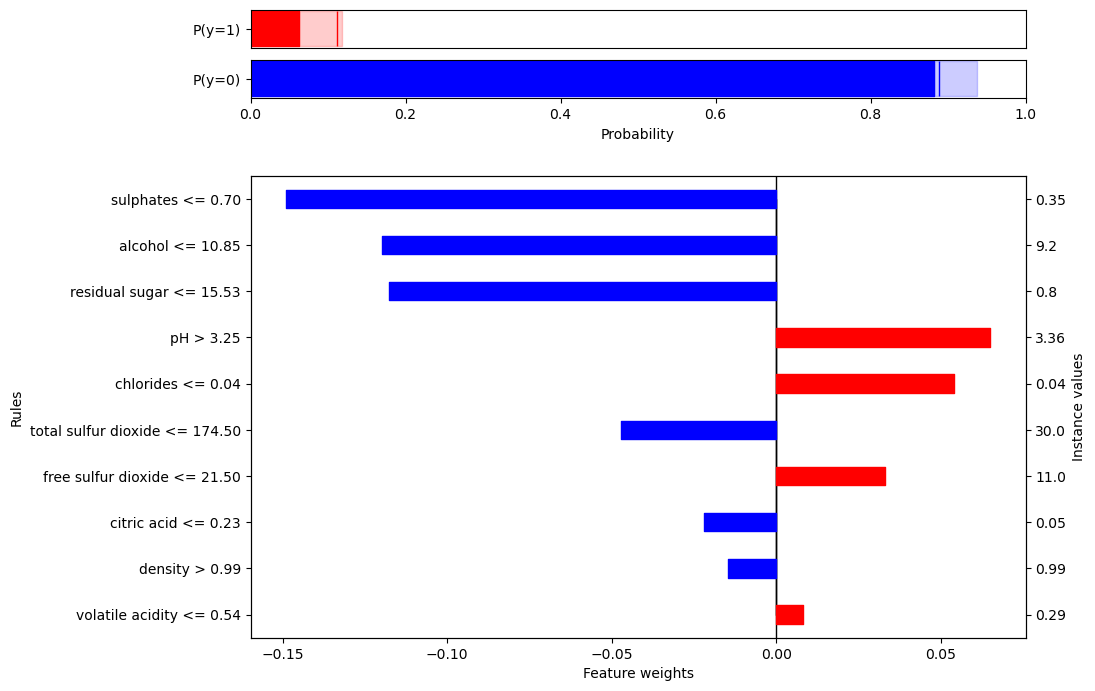

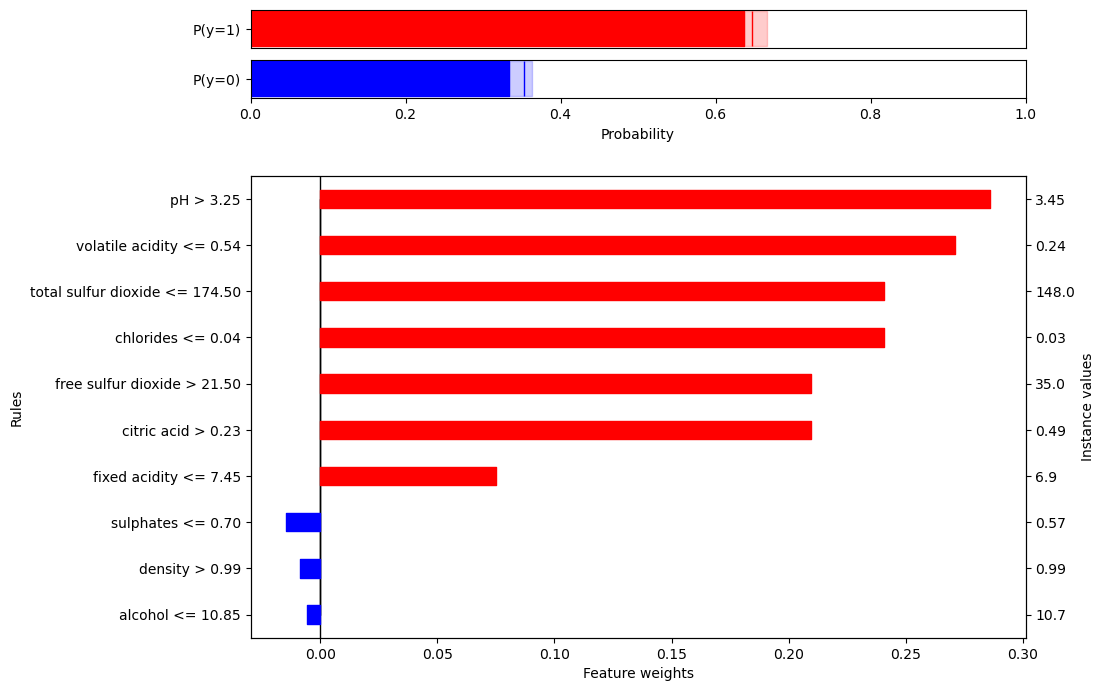

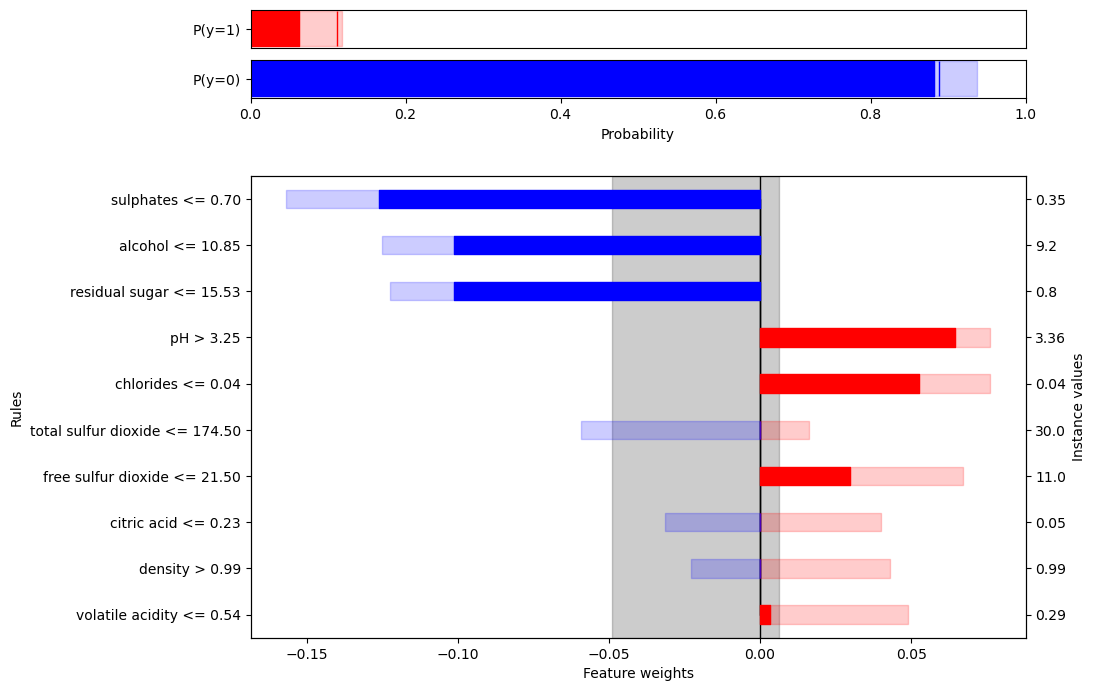

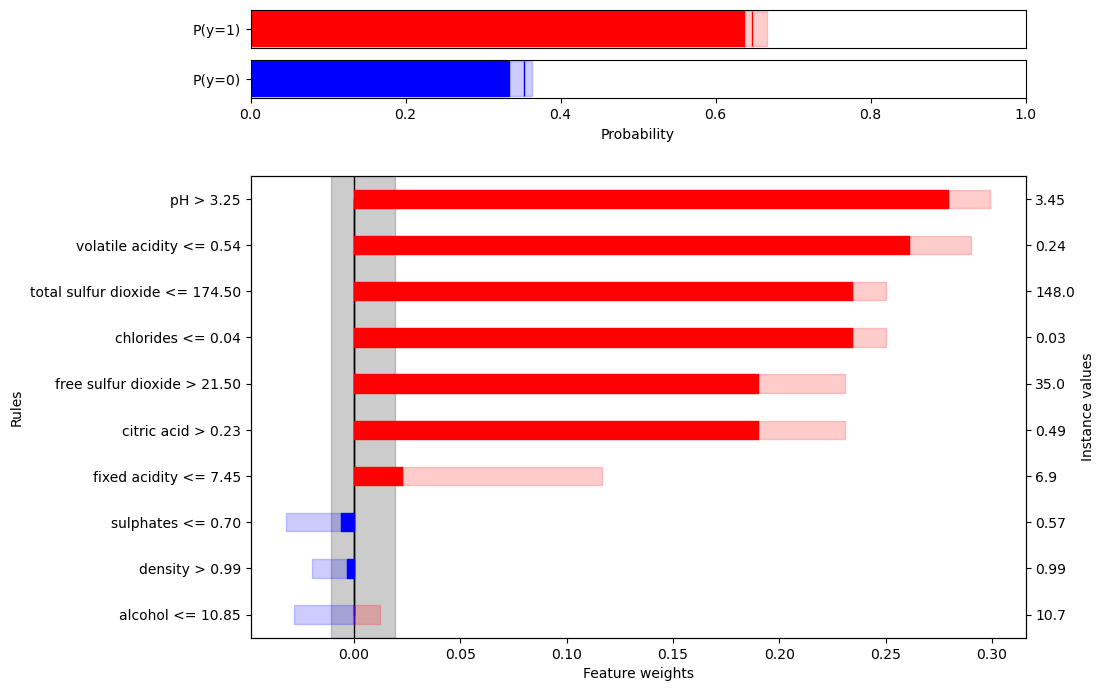

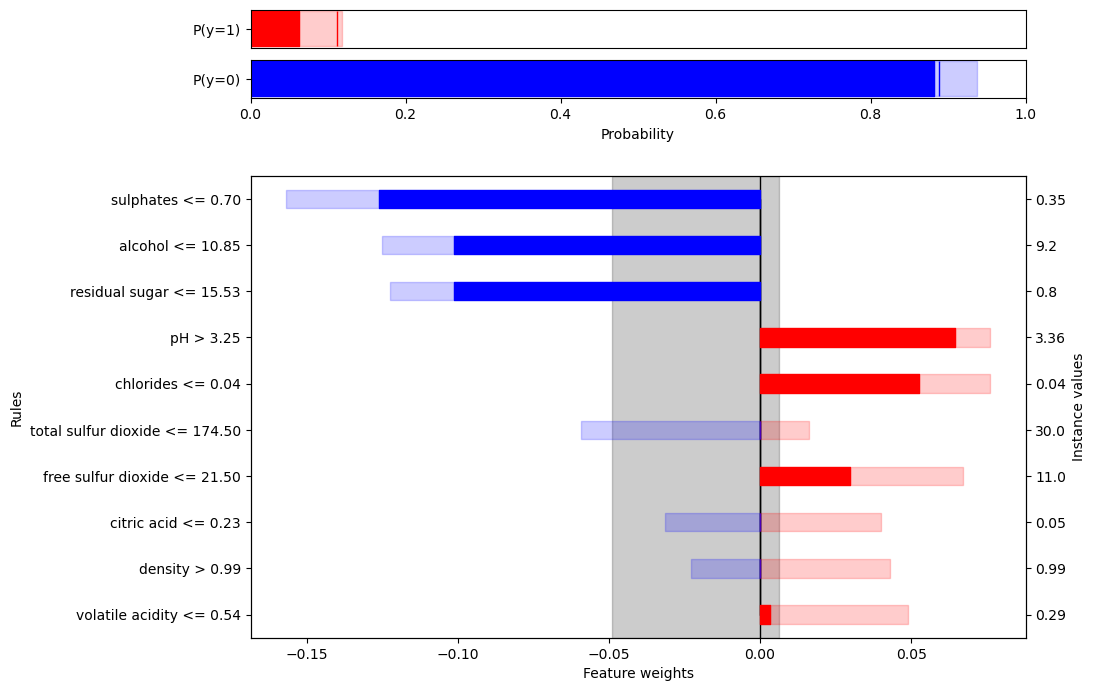

In [9]:
factual_explanations.plot_all()
factual_explanations.plot_all(uncertainty=True)

factual_explanations.plot_explanation(0, uncertainty=True)

You can also add and remove conjunctive rules.

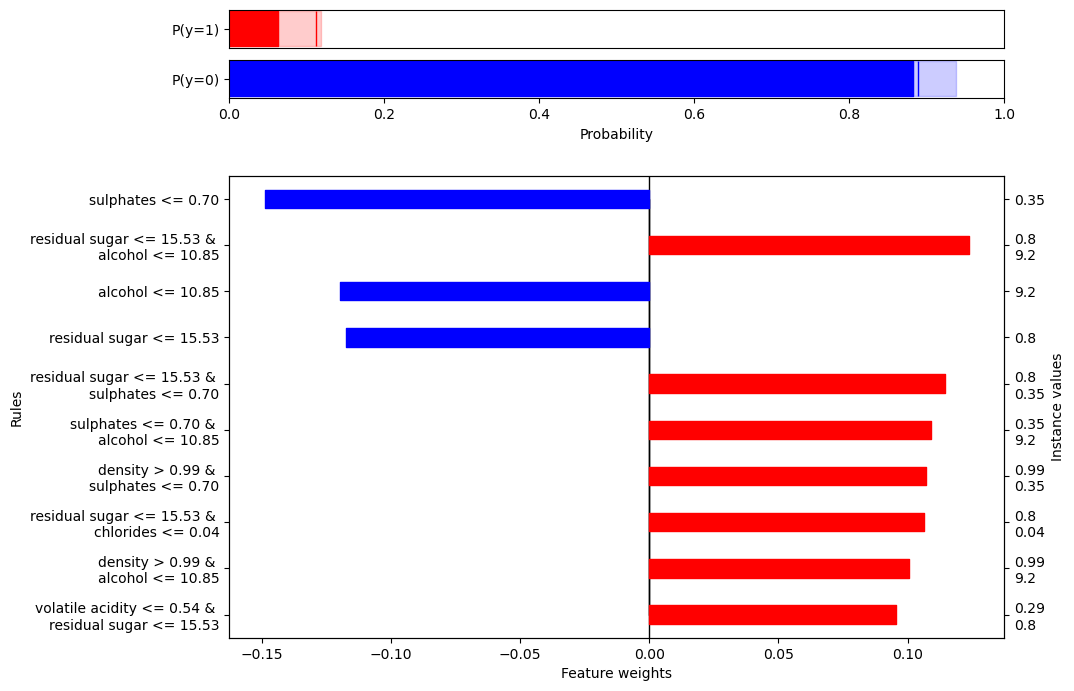

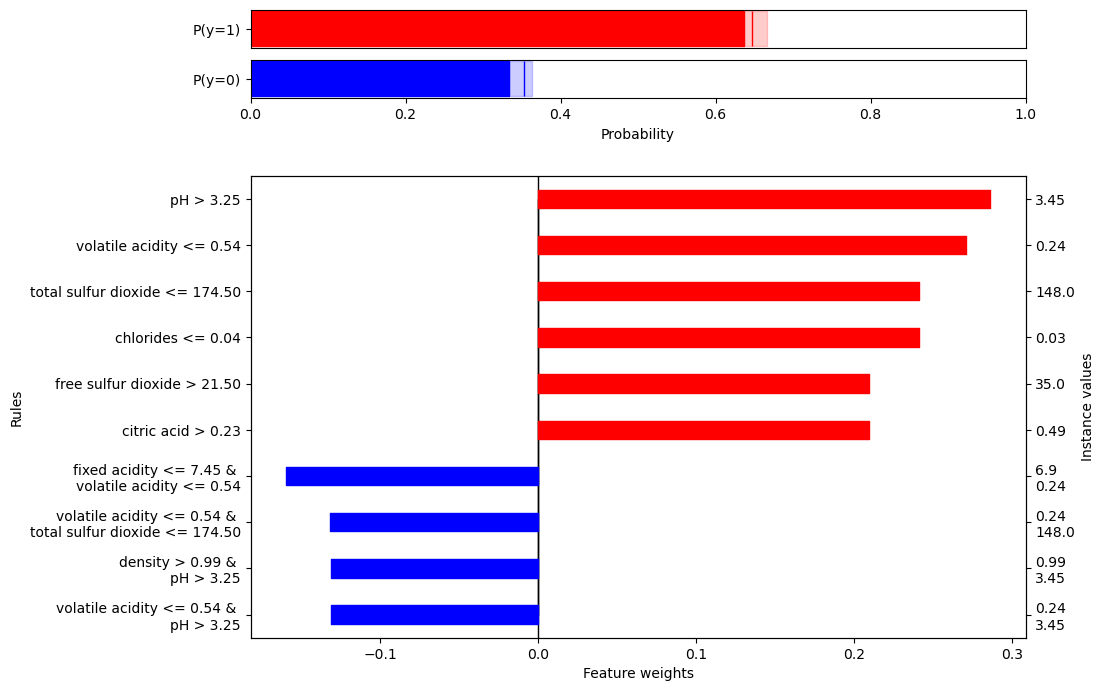

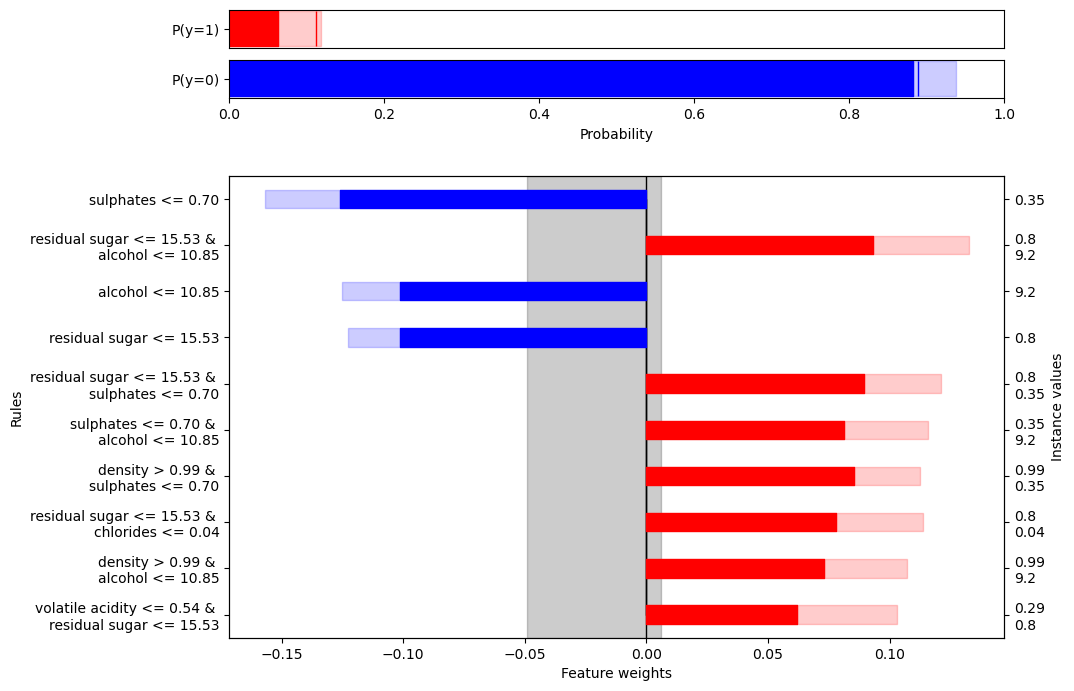

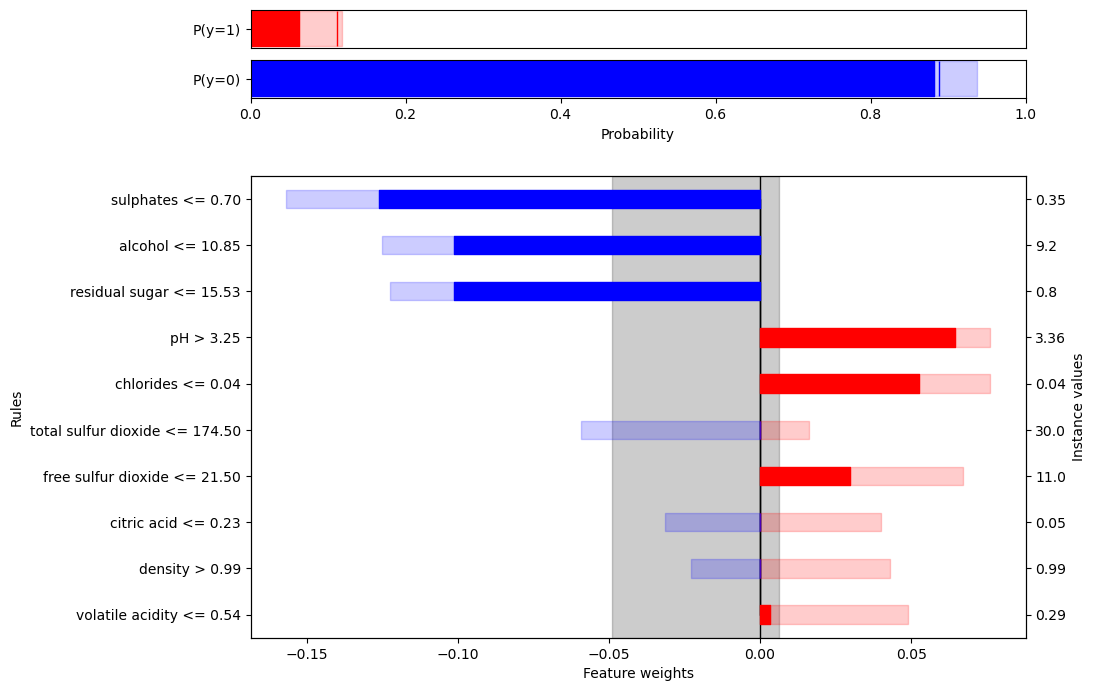

In [10]:
factual_explanations.add_conjunctions().plot_all()
factual_explanations.plot_explanation(0, uncertainty=True)
factual_explanations.remove_conjunctions().plot_explanation(0, uncertainty=True)

#### Counterfactual Explanations
An alternative to factual rules is to extract counterfactual rules. 
`explain_counterfactual` can be called to get counterfactual rules with an appropriate discretizer automatically assigned. Note that the discretizer has changed. 

In [11]:
counterfactual_explanations = classifier.explain_counterfactual(X_test)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'lime.discretize.EntropyDiscretizer'>
	                model=RandomForestClassifier()
	                )

Counterfactuals are also visualized using the `plot_all`. Plotting an individual counterfactual explanation is done using `plot_explanation`, submitting the index to plot. Adding or removing conjunctions is done as before. 

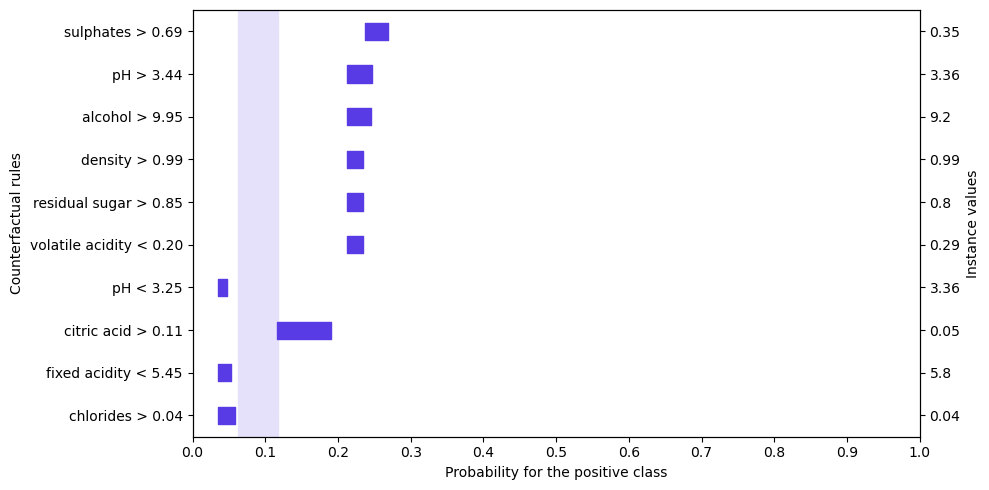

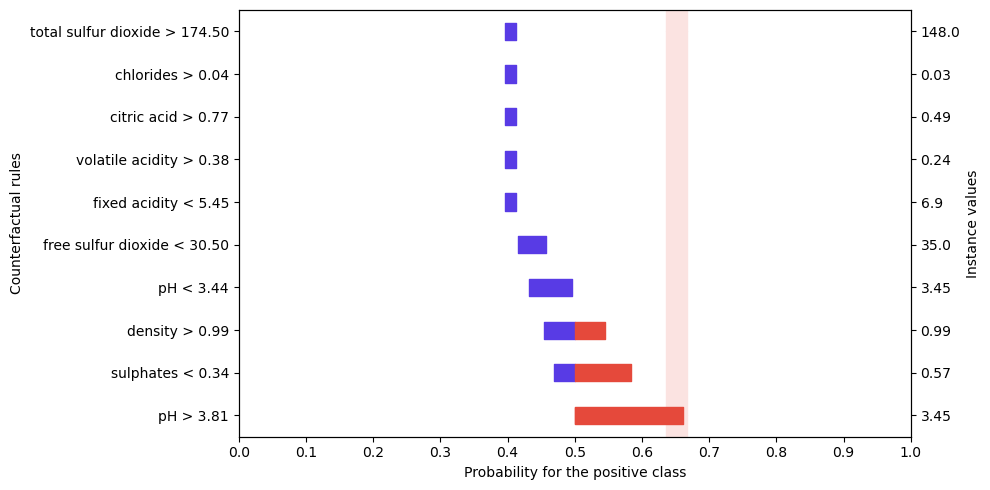

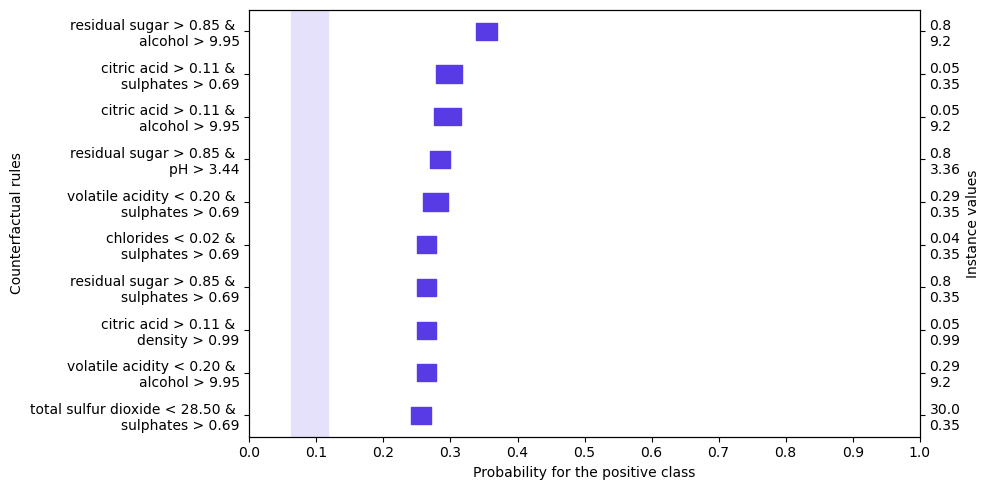

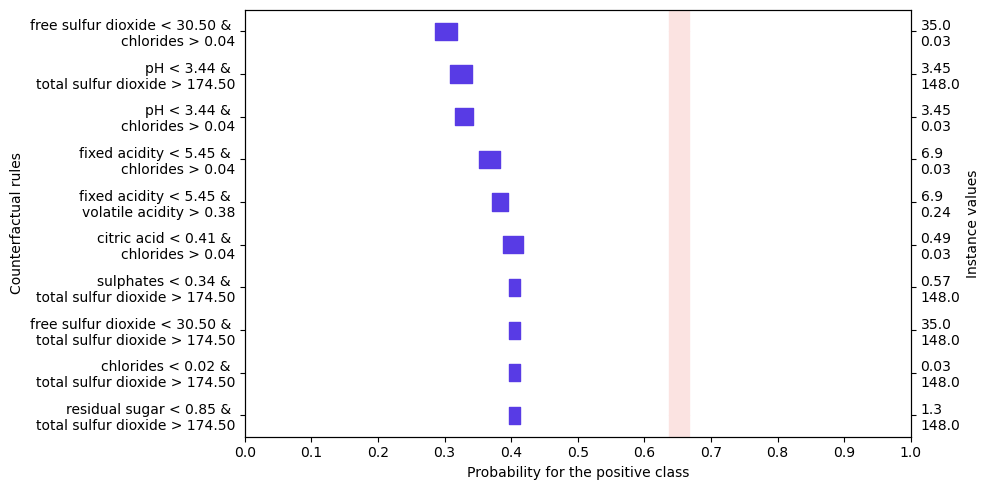

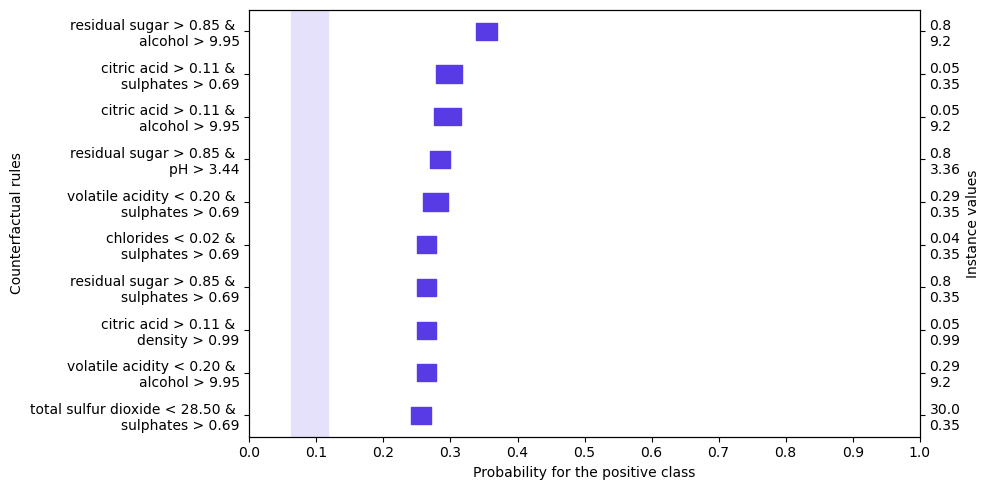

In [12]:
counterfactual_explanations.plot_all()
counterfactual_explanations.add_conjunctions().plot_all()

counterfactual_explanations.plot_explanation(0)

`calibrated_explanations` supports multiclass which is demonstrated in [demo_multiclass](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_multiclass.ipynb). That notebook also demonstrates how both feature names and target and categorical labels can be added to improve the interpretability. 
## Regression
Extracting explanations for regression is very similar to how it is done for classification. First we load and divide the dataset. The target is divided by 1000, meaning that the target is in thousands of dollars.

In [13]:
dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values/1000
y_filter = y < 1000
X = X[y_filter,:]
y = y[y_filter]

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2, random_state=42)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=1000)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We now create our wrapper object, using a `RandomForestRegressor` as learner. 

In [14]:
from sklearn.ensemble import RandomForestRegressor

regressor = WrapCalibratedExplainer(RandomForestRegressor())
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=False, calibrated=False)

We now fit our model using the proper training set.

In [15]:
regressor.fit(X_prop_train, y_prop_train)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=False)

The `WrapCalibratedExplainer` class has a `predict` method that returns the predictions and probability estimates of the underlying classifier. If the model is not yet calibrated, then the underlying models `predict` method is used. If the model is calibrated, then the `predict` method of the calibration model is used.

In [16]:
print(f'Uncalibrated probability estimates: \n{regressor.predict(X_test)}')

Uncalibrated probability estimates: 
[386.8475 439.8388]


c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\core.py:1055: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated predictions.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated predictions.", Warning)


Before we can generate explanations, we need to calibrate our model using the calibration set. No discretizer is yet assigned. We can easily add a `DifficultyEstimator` by assigning a `DifficultyEstimator` when calibrating the model.

In [17]:
from crepes.extras import DifficultyEstimator

regressor.calibrate(X_cal, y_cal, feature_names=feature_names, 
                    difficulty_estimator=DifficultyEstimator().fit(X=X_prop_train, learner=regressor.learner, scaler=True))
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestRegressor()
	                difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False))

Once the model is calibrated, the `predict` and `predict_proba` methods produce calibrated predictions and probability estimates.

In [18]:
prediction, (low, high) = regressor.predict(X_test, uq_interval=True)
print(f'Calibrated prediction: \n{prediction}')
print(f'Calibrated uncertainty interval: [{[(low[i], high[i]) for i in range(len(low))]}]')

Calibrated prediction: 
[385.49980925 437.53987839]
Calibrated uncertainty interval: [[(314.56972275430184, 446.89625954583465), (316.54571945153646, 542.2713433023821)]]


You can also get the probability of the prediction being below a certain threshold using `predict_proba`.

In [19]:
prediction = regressor.predict(X_test, threshold=500)
print(f'Calibrated probabilistic prediction: {prediction}')
proba, (low, high) = regressor.predict_proba(X_test, uq_interval=True, threshold=500)
print(f'Calibrated probabilistic probability estimate [y_hat > threshold, y_hat <= threshold]: \n{proba}')
print(f'Calibrated probabilistic uncertainty interval for y_hat <= threshold: [{[(low[i], high[i]) for i in range(len(low))]}]')

Calibrated probabilistic prediction: ['y_hat <= 500', 'y_hat <= 500']
Calibrated probabilistic probability estimate [y_hat > threshold, y_hat <= threshold]: 
[[0.02222222 0.97777778]
 [0.16000002 0.83999998]]
Calibrated probabilistic uncertainty interval for y_hat <= threshold: [[(0.9775280952453613, 0.9887640476226807), (0.8333333134651184, 0.875)]]


#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. Note that the discretizer is now assigned.

In [20]:
factual_explanations = regressor.explain_factual(X_test)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryRegressorDiscretizer'>
	                model=RandomForestRegressor()
	                difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False))

Regression also offer both regular and uncertainty plots for factual explanations with or without conjunctive rules, in almost exactly the same way as for classification. 

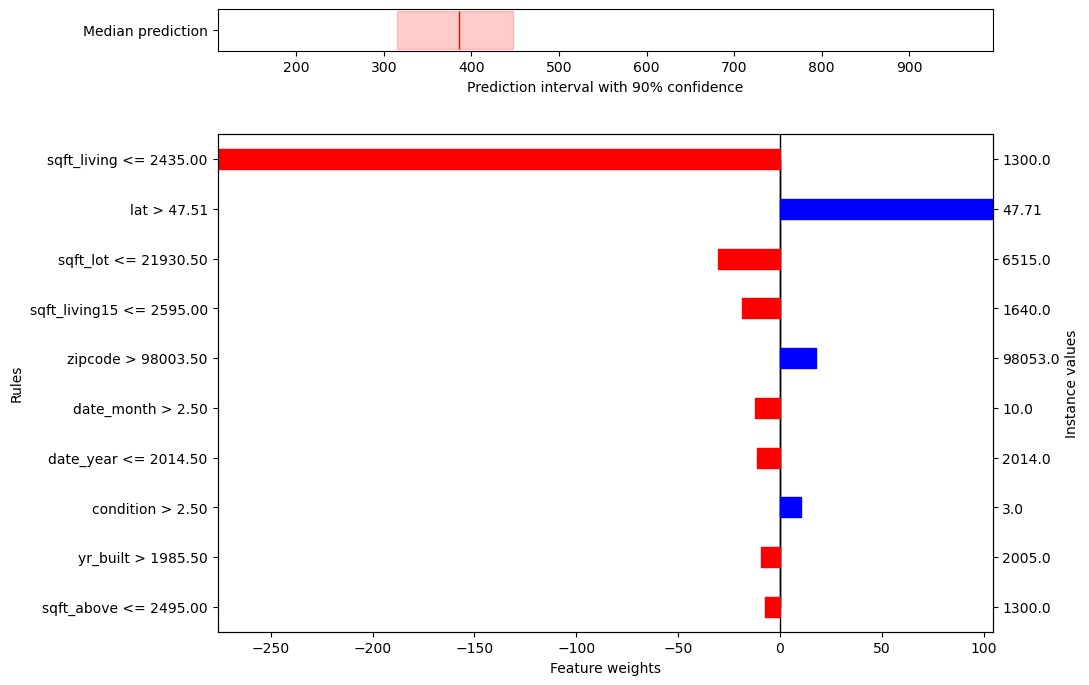

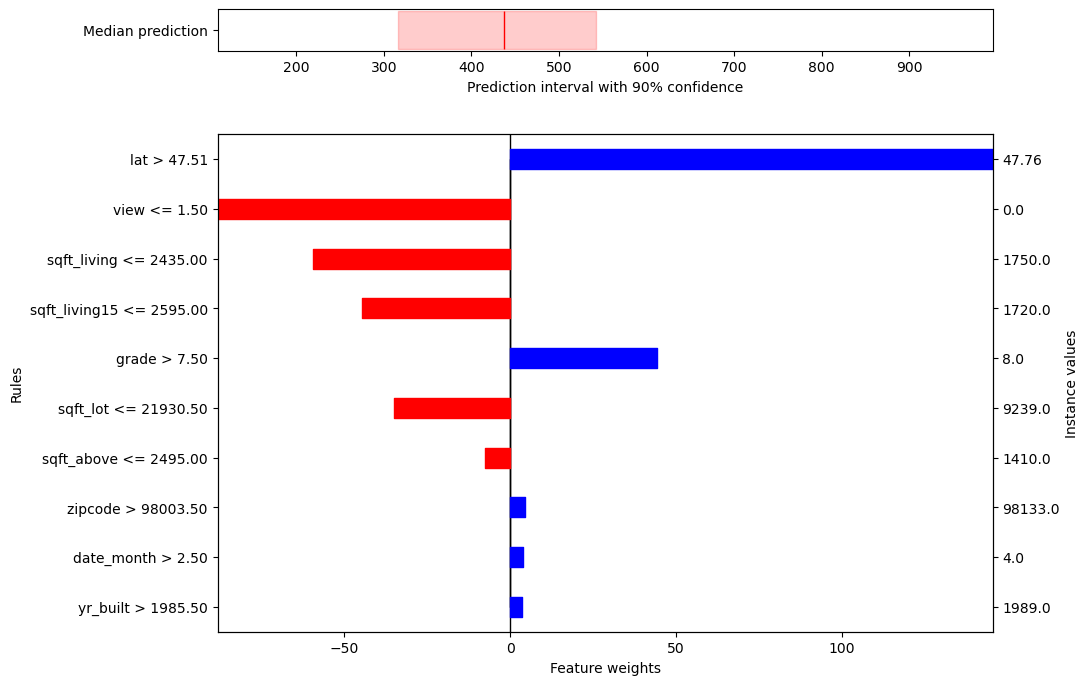

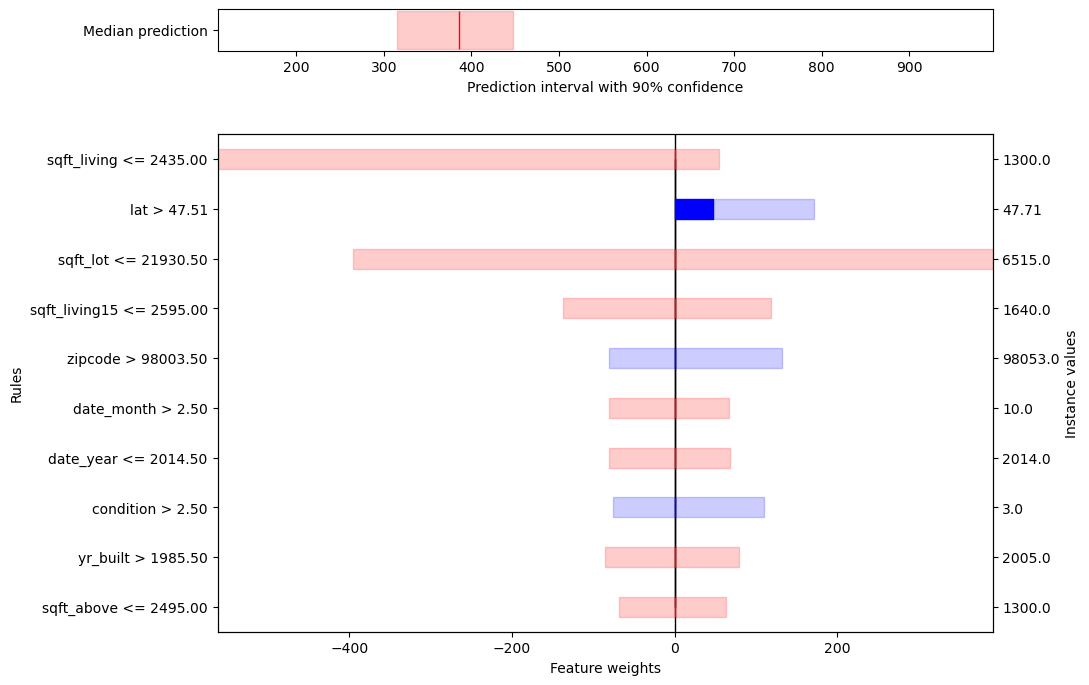

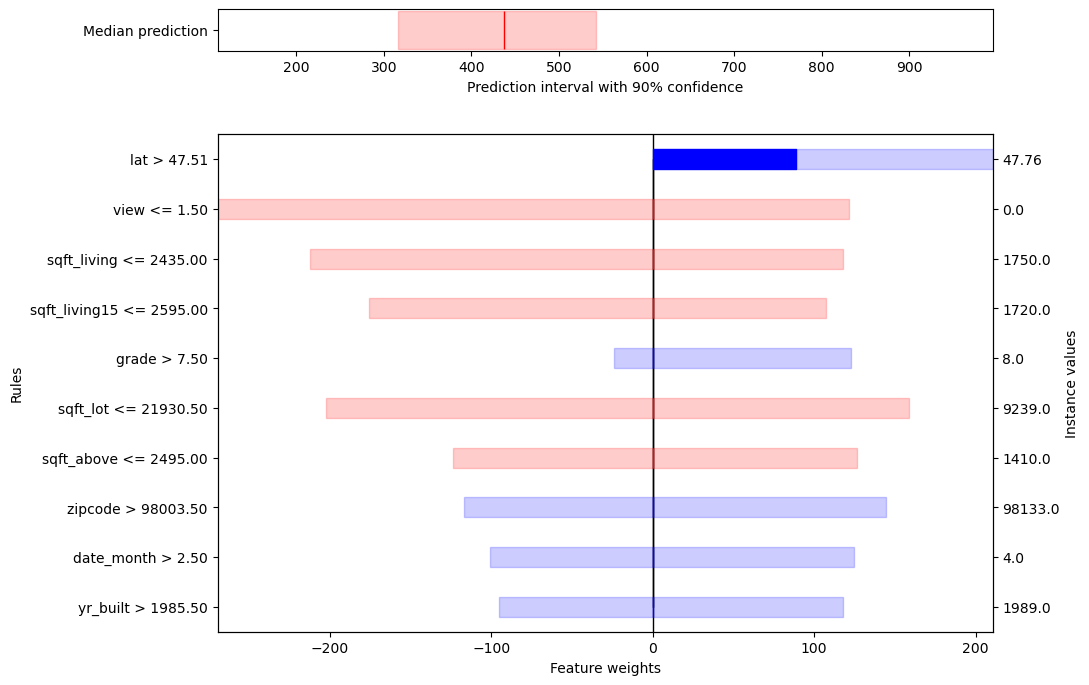

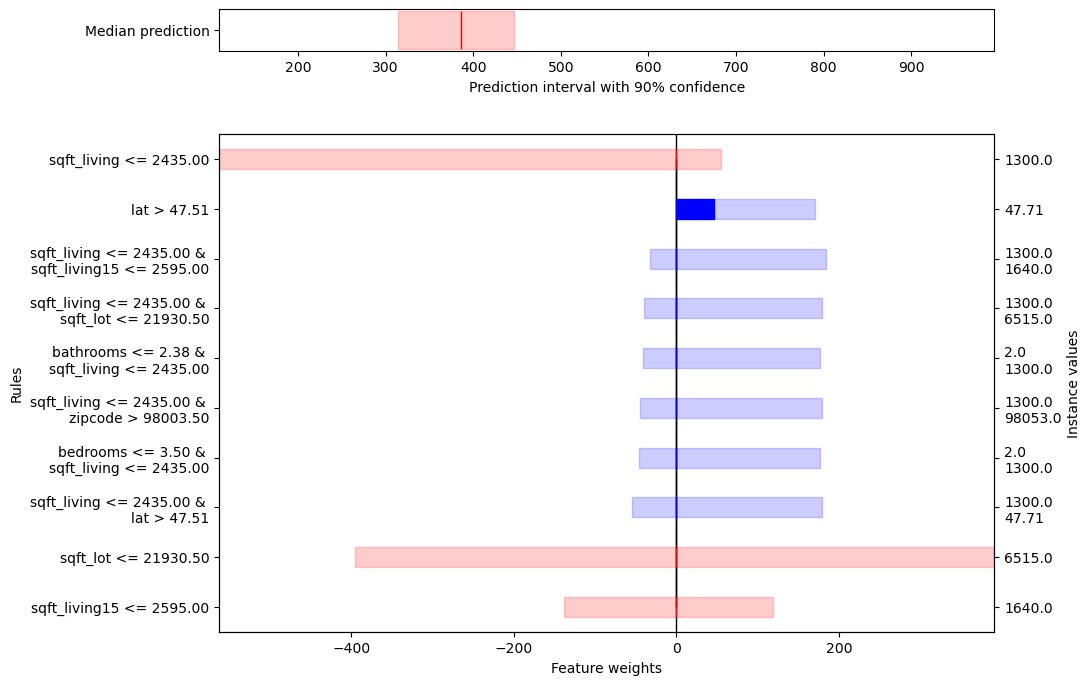

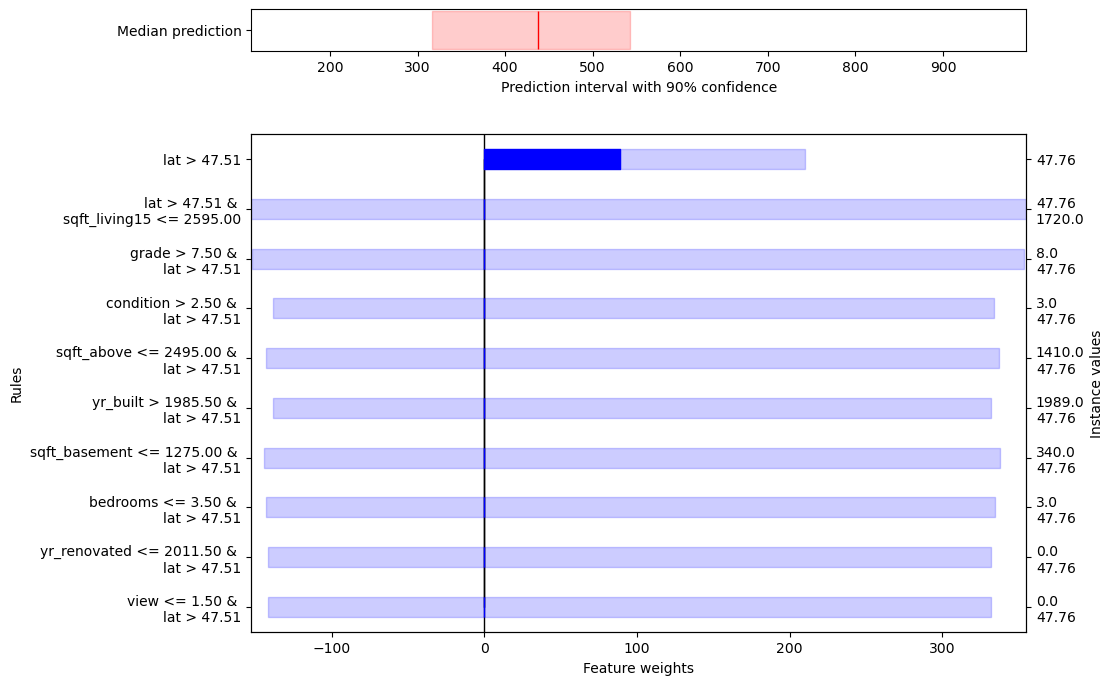

In [21]:
factual_explanations.plot_all()
factual_explanations.plot_all(uncertainty=True)

factual_explanations.add_conjunctions().plot_all(uncertainty=True)

#### Counterfactual Explanations
The `explain_counterfactual` will work exactly the same as for classification. Note that the discretizer is now changed. 

In [22]:
counterfactual_explanations = regressor.explain_counterfactual(X_test)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'calibrated_explanations._discretizers.RegressorDiscretizer'>
	                model=RandomForestRegressor()
	                difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False))

Counterfactual plots work as for classification.

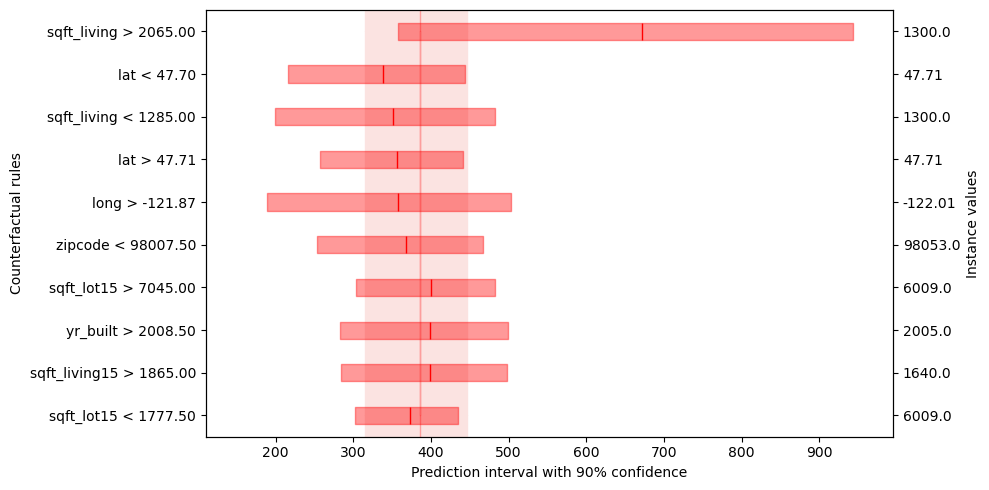

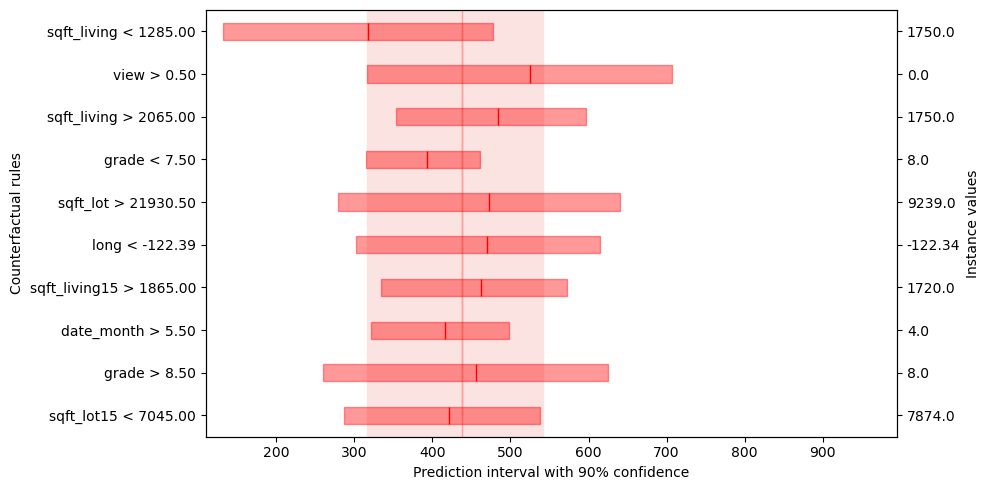

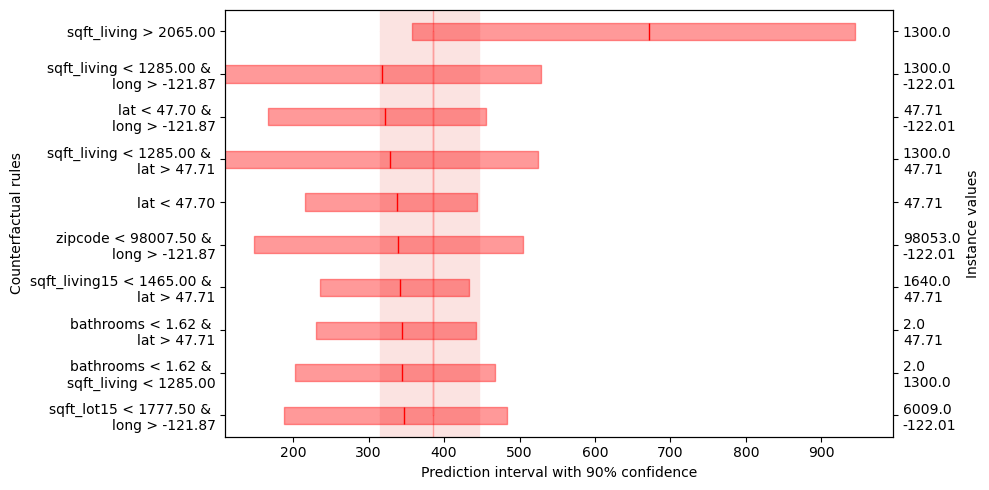

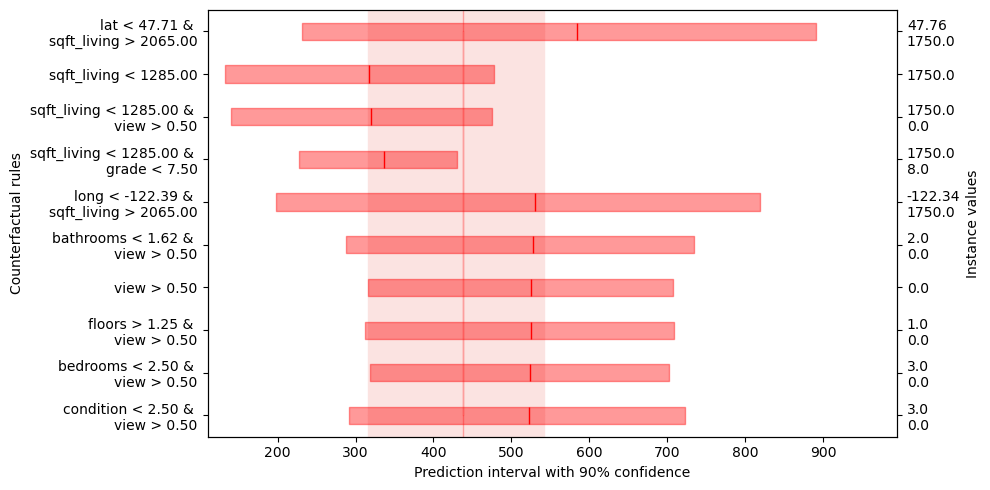

In [23]:
counterfactual_explanations.plot_all()
counterfactual_explanations.add_conjunctions().plot_all()

## Probabilistic Regression
The difference between probabilistic regression and regular regression is that the former returns a probability of the prediction being below a certain threshold. This is useful when the prediction is a time to event, such as time to death or time to failure. 

In [24]:
regressor.calibrate(X_cal, y_cal, feature_names=feature_names)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestRegressor()
	                difficulty_estimator=None)

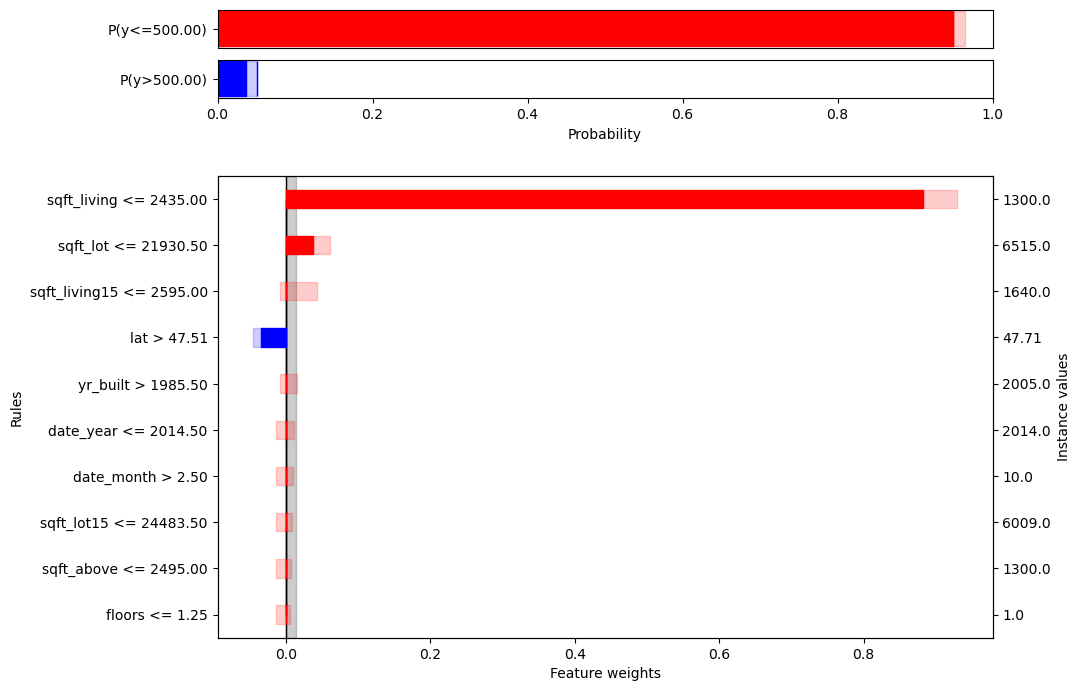

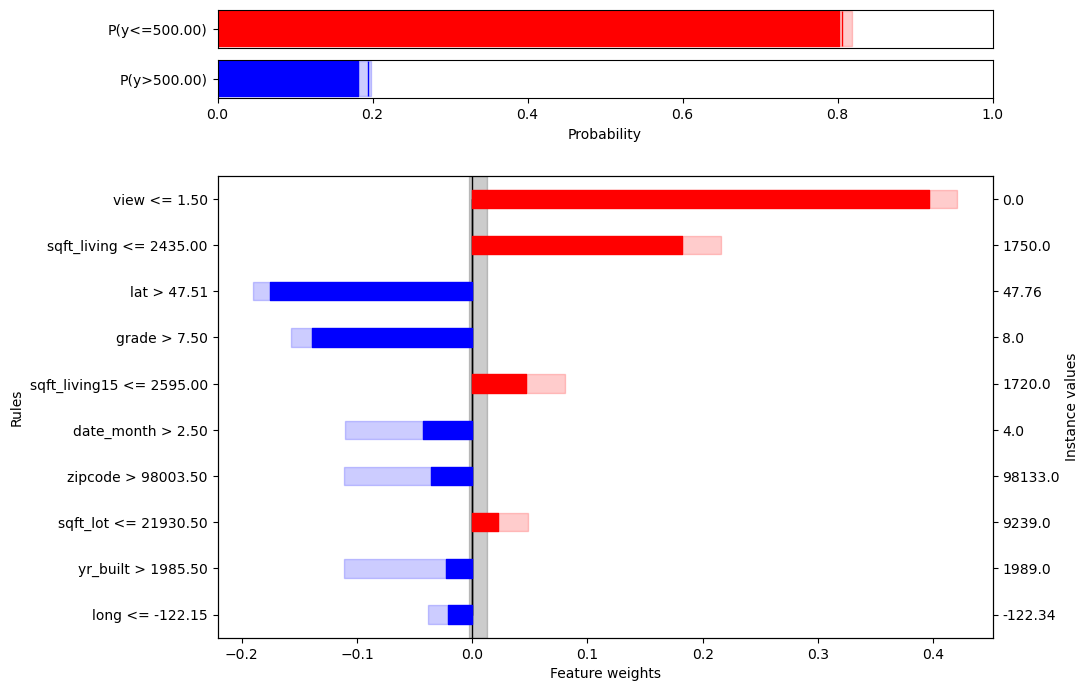

In [25]:
probabilistic_factual_explanations = regressor.explain_factual(X_test, threshold=500)
probabilistic_factual_explanations.plot_all(uncertainty=True)

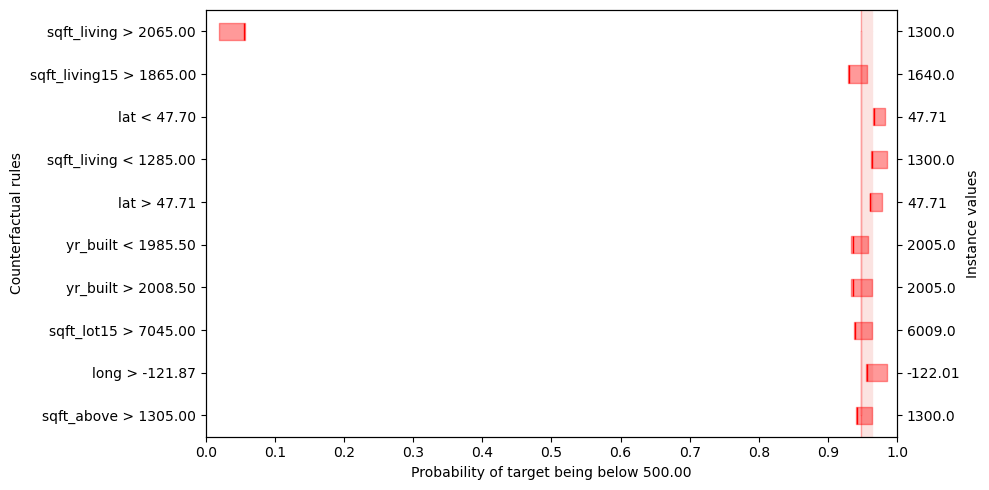

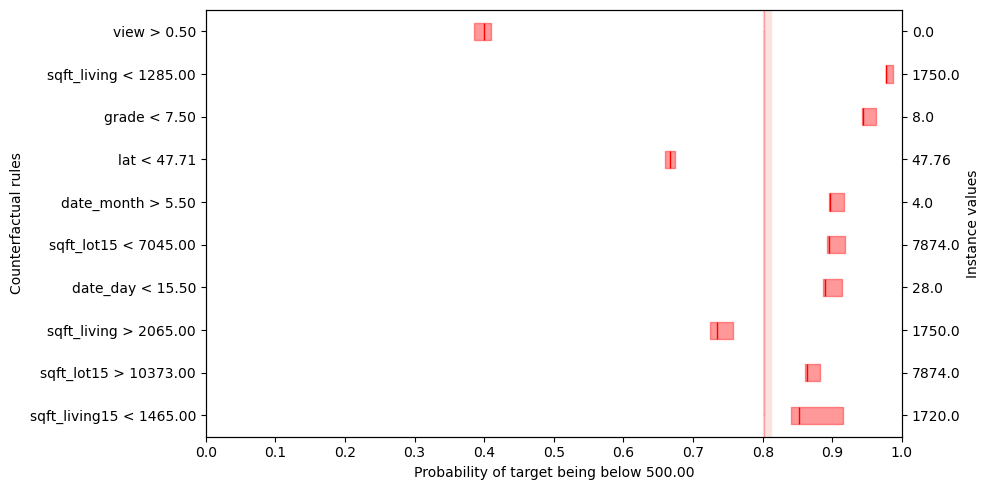

In [26]:
probabilistic_counterfactual_explanations = regressor.explain_counterfactual(X_test, threshold=500)
probabilistic_counterfactual_explanations.plot_all()

Regression offers many more options but to learn more about them, see the [demo_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_regression.ipynb) or the [demo_probabilistic_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_probabilistic_regression.ipynb) notebooks.